In [2]:
import numpy as np
from numpy import linalg as lg
import matplotlib.pyplot as plt
from functions import *

# Optimization problem  
We consider a logistic regression problem
 $$    \min_{x\in \mathbb{R}^d}~~\frac{1}{n}\!\sum_{j=1}^n \log(1 \!+\! \exp(-y_j z_j^{\top} x))
 $$
with a dataset from  LibSVM repository. 

## Data reading

In [3]:
from sklearn.datasets import load_svmlight_file

file_name = "rcv1_train.dat"

data_matrix, data_vector = load_svmlight_file(file_name)
sparse_data_matrix = csr_matrix(data_matrix)
sparse_data_vector = csr_matrix(data_vector).T

m, d = sparse_data_matrix.shape

## Initialization

In [4]:
starting_point = csr_matrix(np.random.rand(d)).T #to copy only

Lipschitz_const = 0.25*data_matrix.multiply(data_matrix).sum(axis = 1)
Lipschitz_max = np.max(Lipschitz_const)

## Functions

In [5]:
def fun(x):
    return f(x, sparse_data_matrix, sparse_data_vector, 0)

def grad(x):
    return f_grad(x, sparse_data_matrix, sparse_data_vector, 0)

def grad_lam(x, g, lam):
    return -g.T.dot(grad(x - lam*g))
    

def l_s_step(x, g, max_iter = 200):
    maxim = Lipschitz_max
    minim = 0.
    for i in range(max_iter):
        current = 0.5*(maxim + minim)
        if grad_lam(x,g,1.0/current) > 0:
            minim = current
        else:
            maxim = current
    return 1./maxim

## Basic methods

In [6]:
def gradient_descent(x_0 = starting_point.copy(), ITE_MAX = 2000, debug = False):
    x_tab = [x_0]
    x = x_0.copy()
    step_size = 1./Lipschitz_max
    for it in range(ITE_MAX):
        x = x - step_size*grad(x)
        x_tab.append(x.copy())
        if debug and it % 50 == 0:
            print(fun(x))
    return x_tab

In [7]:
def steepest_descent(x_0 = starting_point.copy(), ITE_MAX = 2000, l_s_depth = 10, debug = False):
    x_tab = [x_0]
    x = x_0.copy()
    for it in range(ITE_MAX):
        g = grad(x)
        step_size = l_s_step(x,g, l_s_depth)
        x = x - step_size*g
        x_tab.append(x.copy())
        if debug and it % 50 == 0:
            print(fun(x))
    return x_tab

## Basic experiment

In [40]:
GD_it = gradient_descent(ITE_MAX = 10000, debug = True)
SD_it = steepest_descent(ITE_MAX = 10000, debug = True)

1.9380148679123403
1.1545025828964819
0.758626890913211
0.5921490423476069
0.5046254348834557
0.448212383203554
0.4076101398910416
0.37652413158113396
0.35174869924461205
0.33141795028751697
0.31435337686441867
0.2997686903446282
0.2871174123520529
0.2760070814783799
0.266148009670642
0.25732129079337795
0.2493581057397707
0.24212592668587538
0.23551907630413277
0.22945211524024817
0.2238551131115045
0.21867020248491775
0.2138490248111881
0.20935080810926915
0.20514089977183006
0.20118963238494783
0.1974714367170395
0.19396414058184505
0.19064840917752945
0.187507294313742
0.18452586831102524
0.1816909243719937
0.17899072959881776
0.1764148200507773
0.1739538296300463
0.17159934638281918
0.16934379116729797
0.16718031468410982
0.16510270967031493
0.163105335684664
0.16118305440259256
0.1593311737266785
0.15754539932581477
0.1558217924620963
0.154156733161961
0.1525468879477963
0.15098918147596851
0.14948077153318398
0.14801902693002408
0.14660150790214088
0.1452259486888988
0.143890242

In [9]:
fmin = fun(SD_it[-1]) + 10**(-16)

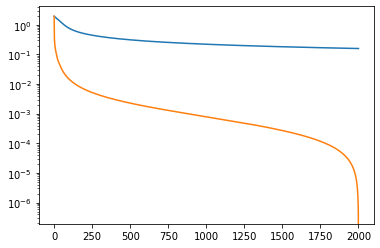

In [10]:
plt.semilogy([fun(x) - fmin for x in GD_it], label = "Gradient descent")
plt.semilogy([fun(x) - fmin for x in SD_it], label = "Steepest descent")
#plt.ylim(10**-3, 10.)
plt.show()

## Monteiro-Svaiter

### Regularized functions
$$
f_{\kappa}(x,y) = f(x) + \frac{\kappa}{2}\|x-y\|^2
$$

In [17]:
def fun_prox(x, y, kappa):
    return fun(x) + 0.5*kappa*lg.norm((x-y).toarray(),2)**2

def grad_prox(x, y, kappa):
    return grad(x) + kappa*(x-y)

def grad_lam_prox(x, g, lam, y, kappa):
    return -g.T.dot(grad_prox(x - lam*g, y, kappa))
    
def l_s_step_prox(x, g,y, kappa, max_iter = 200):
    maxim = Lipschitz_max + kappa
    minim = 0.
    for i in range(max_iter):
        current = 0.5*(maxim + minim)
        if grad_lam_prox(x,g,1.0/current, y, kappa) > 0:
            minim = current
        else:
            maxim = current
    return 1./maxim

### Basic inner methods (different notations)
We need to re-write inner methods GD and SD to use new functions and M.-S. stopping criteria
$$
\|\nabla F_{L, y^k} (x^{k+1})\|_2 \leq \frac{L}{2} \|y^{k+1} - x^k\|_2 
$$

### Adaptive $L_k$ selection

In [11]:
def gradient_descent_prox(x_0 = starting_point.copy(), y_k = starting_point.copy(), L_k = 0., debug = False):
    x_tab = [x_0]
    x = x_0.copy()
    step_size = 2./(Lipschitz_max + 2*L_k)
    it = 1
    while True:
        g = grad_prox(x, y_k, L_k)
        if lg.norm(g.toarray(), 2) <= 0.5*L_k*lg.norm((x - y_k).toarray(), 2):
            break
        x = x - step_size*g       
        x_tab.append(x.copy())
        if debug and it % 50 == 0:
            print(fun(x))
        it += 1 #for debug only
    return it, x_tab

In [12]:
def steepest_descent_prox(x_0 = starting_point.copy(),y_k = starting_point.copy(), L_k = 0., l_s_depth = 10, debug = False):
    x_tab = [x_0]
    x = x_0.copy()
    it = 1
    while True:
        g = grad_prox(x, y_k, L_k)
        if lg.norm(g.toarray(), 2) <= 0.5*L_k*lg.norm((x - y_k).toarray(), 2):
            break
        step_size = l_s_step_prox(x,g, y_k, L_k, l_s_depth)
        x = x - step_size*g
        x_tab.append(x.copy())
        if debug and it % 50 == 0:
            print(fun(x))
        it += 1 #for debug only
    return it, x_tab

### Small test

Minimization of $\ell_2$ regularized problem using regularized methods

In [ ]:
y_0 = csr_matrix(np.zeros(d)).T


GD_it_prox = gradient_descent_prox(y_k = y_0.copy(), L_k = 0.01, debug = True)
SD_it_prox = steepest_descent_prox(y_k = y_0.copy(), L_k = 0.01, debug = True)

In [ ]:
fmin = fun_prox(SD_it_prox[1][-1], y_0, 0.01) + 10**(-16)

In [ ]:
plt.semilogy([fun_prox(x, y_0, 0.01) - fmin for x in GD_it_prox[1]], label = "Gradient descent")
plt.semilogy([fun_prox(x, y_0, 0.01) - fmin for x in SD_it_prox[1]], label = "Steepest descent")
#plt.ylim(10**-3, 10.)
plt.show()

### Update of constants
$$
a_{k+1} = \frac{\frac{1}{L_k} + \sqrt{\frac{1}{L^2_k} + \frac{4 A_k}{L_k}}}{2}
$$

$$
A_{k+1} = A_k + a_{k+1}
$$

$$
y^k = \dfrac{A_{k}}{A_{k+1}} x^{k} + \dfrac{a_{k+1}}{A_{k+1}} z^{k}
$$

$$
z^{k+1}=z^{k}-a_{k+1} \nabla f\left(x^{k+1}\right)
$$

In [13]:
def new_a(L_k, A_k):
    return 0.5/L_k + 0.5*np.sqrt(1./L_k**2 + (4*A_k)/L_k)

def new_A(oldA, newa):
    return oldA + newa

def new_prox_center(x_k, z_k, oldA, newa):
    newA = new_A(oldA, newa)
    return oldA/newA*x_k + newa/newA*z_k

def new_z(oldz, newa, g):
    return oldz - newa*g

#### M.-S. parameters

We are going to use the following algorithm parameters:

 $c_c$ - complexity difference to stop tuning $L_k$ 
 
 $c_b$ - increasing factor
 
 $c_a$ - decreasing factor
 
 Also we assume $L_l$ and $L_u$ as a lower/upper-bounds on posiible $L_k$

In [52]:
c_c = 1.3
c_a = 3.
c_b = 2.
L_l = 0.00001*Lipschitz_max
L_u = 1.*Lipschitz_max

In [27]:
def Monteiro_Svaiter_SD(x_0 = starting_point.copy(), l_s_depth = 10, ITE_MAX = 4000, debug = False, const_c = c_c, const_a = c_a, const_b = c_b):
    #initialization
    x_k = x_0.copy()
    z_k = x_0.copy()
    y_k = csr_matrix(np.zeros(d)).T
    oldA = 0.
    olda = 0.
    L_k = Lipschitz_max
    global_x_tab = [x_0.copy()]
    global_it = 1
    restarts = []
    
    #main loop
    for it in range(ITE_MAX):
        #re-initialization
        it_prev = 0
        total_it = 0
        x_tab_prev = []
        L_k = const_b*min(const_a*L_k, L_u)
        print(L_k)
        newa = new_a(L_k, oldA)
        newA = new_A(oldA, newa)
        y_k = new_prox_center(x_k, z_k, oldA, newa)
        t = 0
        #inner loop
        while True:
            t += 1
            L_k = max(L_k/const_b, L_l)
            it_new, x_tab_new = steepest_descent_prox(y_k, y_k, L_k, l_s_depth, debug) #warm start??
            total_it += it_new
            print(it_new, it_prev)
            if (t > 1 and it_new/(it_prev + 0.)>= const_c) or L_k == L_l:
                x_rest = global_x_tab[-1].copy()
                wait_it = total_it - it_prev
                for i in range(it_prev):
                    global_x_tab = global_x_tab + [x_rest.copy()]
                global_x_tab = global_x_tab + x_tab_prev
                global_it += it_prev
                L_prev = L_k
                break
            else:
                x_tab_prev = x_tab_new
                it_prev = it_new
                L_prev = L_k
                
                
        x_k = x_tab_prev[-1].copy()
        
        #finalizing
        
        oldA = newA
        olda = newa
        z_k = new_z(z_k, newa, grad_prox(x_k, y_k, L_prev))
        
        if debug:
            print("End of inner and restart \n")
            print(len(global_x_tab), it, fun(x_k))
    
    return global_x_tab, restarts

In [22]:
def Monteiro_Svaiter_GD(x_0 = starting_point.copy(), l_s_depth = 10, ITE_MAX = 1000, debug = False, const_c = c_c, const_a = c_a, const_b = c_b):
    #initialization
    x_k = x_0.copy()
    z_k = x_0.copy()
    y_k = csr_matrix(np.zeros(d)).T
    oldA = 0.
    olda = 0.
    L_k = Lipschitz_max
    global_x_tab = [x_0.copy()]
    global_it = 1
    restarts = []
    
    #main loop
    for it in range(ITE_MAX):
        #re-initialization
        it_prev = 0
        x_tab_prev = []
        #L_k = const_b*min(const_a*L_k, L_u)
        print(L_k)
        newa = new_a(L_k, oldA)
        newA = new_A(oldA, newa)
        y_k = new_prox_center(x_k, z_k, oldA, newa)
        it_new, x_tab_new = gradient_descent_prox(y_k, y_k, L_k, debug) #warm start??
        global_x_tab = global_x_tab + x_tab_new
        global_it += it_new
                
        x_k = x_tab_new[-1].copy()
        
        #finalizing
        
        oldA = newA
        olda = newa
        z_k = new_z(z_k, newa, grad_prox(x_k, y_k, L_k))
        
        if debug:
            print("End of inner and restart \n")
            print(global_it, it, fun(x_k))
    
    return global_x_tab, restarts

In [53]:
global_it2, rest2 = Monteiro_Svaiter_SD(ITE_MAX = 2000, debug = True)

0.3750000000000018
2 0
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
3 2
End of inner and restart 

5 0 0.8971562781196027
0.0038536733146294876
2 0
3 2
End of inner and restart 

9 1 0.9780949969009033
0.00513823108617265
2 0
2 2
3 2
End of inner and restart 

13 2 0.7466873419978153
0.004567316521042355
2 0
3 2
End of inner and restart 

17 3 0.6417357671644414
0.006089755361389807
2 0
2 2
3 2
End of inner and restart 

21 4 0.5275606191381036
0.005413115876790939
2 0
3 2
End of inner and restart 

25 5 0.46903204527179787
0.007217487835721251
2 0
2 2
3 2
End of inner and restart 

29 6 0.40932465066813517
0.006415544742863334
2 0
2 2
3 2
End of inner and restart 

33 7 0.36370224281604896
0.0057027064381007415
2 0
2 2
3 2
End of inner and restart 

37 8 0.32610033938181415
0.005069072389422881
2 0
3 2
End of inner and restart 

41 9 0.29894899892432847
0.0067587631858971745
2 0
2 2
3 2
End of inner and restart 

45 10 0.27447414067664105
0.006007789498575267
2 0
2 2
3 2
End of inn

In [ ]:
global_it_gd, rest_gd = Monteiro_Svaiter_GD(ITE_MAX = 2000, debug = True)

In [30]:
fmin = min([fun(x) for x in global_it])

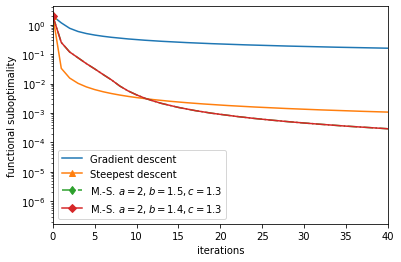

In [56]:
plt.semilogy([fun(x) - fmin for x in GD_it[0:-1:50]], label = "Gradient descent")
plt.semilogy([fun(x) - fmin for x in SD_it[0:-1:50]], '^-', markevery = 100, label = "Steepest descent")
# plt.semilogy([fun(x) - fmin for x in global_it5[:2000]], '*-.', markevery = 1100, label = "M.-S. $a = 2, b = 1.3, c = 1.4$")
# plt.semilogy([fun(x) - fmin for x in global_it4[:2000]], '<-.', markevery = 1200, label = "M.-S. $a = 3, b = 2, c = 1.4$")
# plt.semilogy([fun(x) - fmin for x in global_it3[:2000]], 'x-.', markevery = 1300, label = "M.-S. $a = 6, b = 3, c = 2$")
plt.semilogy([fun(x) - fmin for x in global_it[0:-1:50]], 'd-.', markevery = 100, label = "M.-S. $a = 2, b = 1.5, c = 1.3$")
plt.semilogy([fun(x) - fmin for x in global_it2[0:-1:50]], 'D-', markevery = 100, label = "M.-S. $a = 2, b = 1.4, c = 1.3$")


plt.legend()
plt.xlabel("iterations")
plt.ylabel("functional suboptimality")
#plt.ylim(10**-15, 10.)
plt.xlim(0, 40)
# tkz.save("subopt.tex")
plt.show()


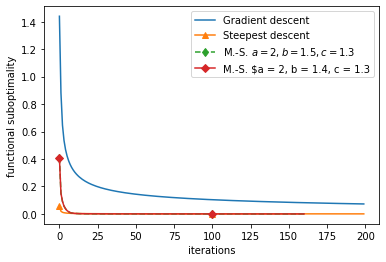

In [55]:
plt.plot([fun(x) - fmin for x in GD_it[30:-1:50]], label = "Gradient descent")
plt.plot([fun(x) - fmin for x in SD_it[30:-1:50]], '^-', markevery = 100, label = "Steepest descent")
# plt.plot([fun(x) - fmin for x in global_it5[30:2000]], '*-.', markevery = 1100, label = "M.-S. $a = 2, b = 1.3, c = 1.4$")
# plt.plot([fun(x) - fmin for x in global_it4[30:2000]], '<-.', markevery = 1200, label = "M.-S. $a = 3, b = 2, c = 1.4$")
# plt.plot([fun(x) - fmin for x in global_it3[30:2000]], 'x-.', markevery = 1300, label = "M.-S. $a = 6, b = 3, c = 2$")
plt.plot([fun(x) - fmin for x in global_it[30:-1:50]], 'd--', markevery = 100, label = "M.-S. $a = 2, b = 1.5, c = 1.3$")
plt.plot([fun(x) - fmin for x in global_it2[30:-1:50]], 'D-', markevery = 100, label = "M.-S. $a = 2, b = 1.4, c = 1.3")

plt.legend()
plt.xlabel("iterations")
plt.ylabel("functional suboptimality")
#plt.ylim(0, 0.04)
#plt.xlim(0, 2000)
# tkz.save("opt.tex")
plt.show()

In [ ]:
global_it, rest = global_it, rest # a = 2, c = 1.3, b = 1.5 L_l = 0.0001 Lf, L_u = L_f

In [ ]:
global_it2, rest2 = global_it, rest # a = 6, c = 1.4, b = 2 L_l = 0.01 Lf, L_u = L_f

In [ ]:
global_it3, rest3 = global_it, rest # a = 6, c = 2., b = 3. L_l = 0.01 Lf, L_u = L_f

In [ ]:
global_it4, rest4 = global_it, rest # a = 3, c = 1.4, b = 2. L_l = 0.01 Lf, L_u = L_f

In [ ]:
global_it5, rest5 = global_it, rest # a = 2, c = 1.4, b = 1.3 L_l = 0.01 Lf, L_u = L_f

In [ ]:
global_it6, rest6 = global_it, rest # a = 2, c = 1.3, b = 1.5 L_l = 0.01 Lf, L_u = L_f

In [42]:
file_name = "rcv_GD.dat"
out_file = open(file_name, 'w')
line = "Ite Functional_value\n"
print(line)
out_file.write(line)

for i in range(len(GD_it)):
    line = "{} {}\n".format(i, fun(global_it[i]))
    out_file.write(line)
    print(line)
out_file.close()

Ite Functional_value

0 1.956656242187084

1 1.956656242187084

2 1.956656242187084

3 1.956656242187084

4 0.8971562781196027

5 0.8971562781196027

6 0.8971562781196027

7 1.9415045711516106

8 0.9780949969009033

9 0.9780949969009033

10 0.9780949969009033

11 1.3344036149857714

12 0.7466873419978153

13 0.7466873419978153

14 0.7466873419978153

15 0.9780799093759145

16 0.6417357671644414

17 0.6417357671644414

18 0.6417357671644414

19 0.7445714584233254

20 0.5275606191381036

21 0.5275606191381036

22 0.5275606191381036

23 0.5931200557046733

24 0.46903204527179787

25 0.46903204527179787

26 0.46903204527179787

27 0.4992562505475303

28 0.40932465066813517

29 0.40932465066813517

30 0.40932465066813517

31 0.4281682507653387

32 0.36370224281604896

33 0.36370224281604896

34 0.36370224281604896

35 0.3747778055223624

36 0.32610033938181415

37 0.32610033938181415

38 0.32610033938181415

39 0.33178029118093455

40 0.29894899892432847

41 0.29894899892432847

42 0.298948

IndexError: list index out of range